In [1]:
from qiskit import *
from qiskit import Aer, transpile
from qiskit.visualization import plot_histogram
import numpy as np
%matplotlib inline

### Sbox

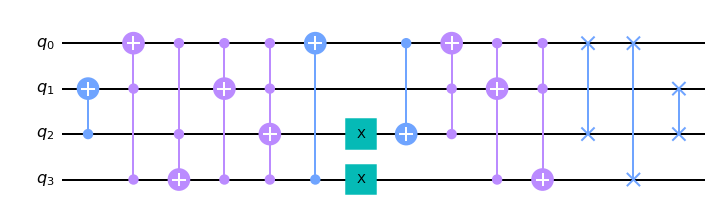

In [35]:
sbox = QuantumCircuit(4)
qubits = [
    [2,1],
    [3,1,0],
    [0,2,3],
    [0,3,1],
    [0,1,3,2],
    [3,0],
    [2],
    [3],
    [0,2],
    [1,2,0],
    [0,3,1],
    [0,1,3]
]

for i in qubits:
    if len(i) == 1:
        sbox.x(i[0])
    elif len(i) == 2:
        sbox.cnot(i[0],i[1])
    elif len(i) == 3:
        sbox.toffoli(i[0],i[1],i[2])
    else:
        sbox.mct(i[:-1],i[-1])

sbox.swap(0,2)
sbox.swap(0,3)
sbox.swap(1,2)

sbox.draw('mpl')

In [36]:
shots = 1000
simulator = Aer.get_backend('qasm_simulator')

for i in range(16):
    
    num = bin(i)[2:][::-1]
    qc = QuantumCircuit(4)
    
    for index, j in enumerate(num):
        if j == '1':
            qc.x(3 - index)
            
    qc = qc.compose(sbox,range(4))
    qc.measure_all()
    
    res = execute(qc,backend=simulator, shots=shots).result()
    counts = res.get_counts(qc)
    s = list(list(counts.keys())[0])
    
    out = int("".join(s[::-1]),2)
    print(i, out)
    
    del qc

0 9
1 4
2 10
3 11
4 13
5 1
6 8
7 5
8 6
9 2
10 0
11 3
12 12
13 14
14 15
15 7


In [25]:
sbox_gate = sbox.to_gate()
sbox_gate.name = 'SN'

### MC

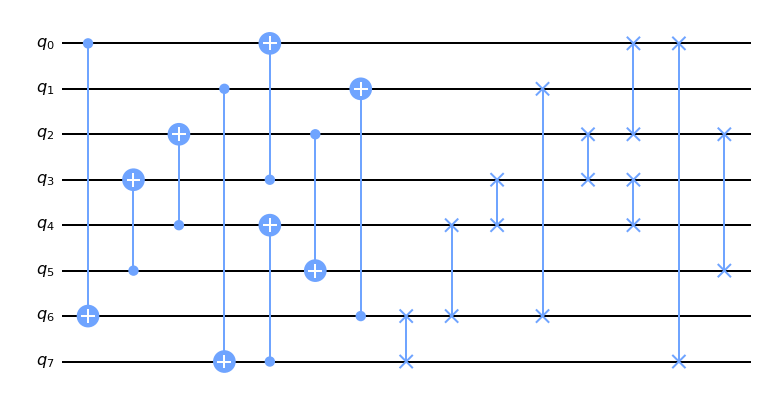

In [39]:
mc = QuantumCircuit(8)
qubits = [
    [0,6],
    [5,3],
    [4,2],
    [1,7],
    [7,4],
    [2,5],
    [3,0],
    [6,1]
]

for i in qubits:
    mc.cnot(i[0],i[1])

mc.swap(6,7)
mc.swap(6,4)
mc.swap(4,3)
mc.swap(3,2)
mc.swap(2,0)

mc.swap(0,7)
mc.swap(1,6)
mc.swap(2,5)
mc.swap(3,4)

mc.draw('mpl')

In [40]:
mix_col = np.array([[1, 4], [4, 1]])
def galoisMult(b, a):
    p = 0
    hiBitSet = 0
    for i in range(4):
        if b & 1 == 1:
            p ^= a
        a <<= 1
        hiBitSet = a & 0x10
        if hiBitSet:
            a ^= 0x13
        b >>= 1
    return p

def mix_column(state):
    res = np.zeros((2, 2)).astype(int)
    for i in range(2):
        for j in range(2):
            for k in range(2):
                res[i][j] ^= galoisMult(mix_col[i][k],state[k][j])
    return res

In [41]:
state = np.zeros((2,2)).astype(int)
count = 0
test = [0]*8
for i in range(16):
    state[0][0] = i
    for j in range(16):
        state[1][0] = j
        mc_state = mix_column(state)
        actual = ((mc_state[0][0] << 12) | (mc_state[1][0] << 8) | (mc_state[0][1] << 4) | mc_state[1][1])
        
        qc = QuantumCircuit(8)
        
        num = ((state[0][0] << 12) | (state[1][0] << 8) | (state[0][1] << 4) | state[1][1])
        num = bin(num)[2:][::-1]
        for index,k in enumerate(num):
            if k == '1':
                qc.x(7-index)
            
        qc = qc.compose(mc, range(8))
        qc.measure_all()
        
        res = execute(qc,backend=simulator, shots=shots).result()
        counts = res.get_counts(qc) 
    
        out = list(counts.keys())[0][::-1] + '00000000'
        out = int(out, 2)
        
        if actual == out:
            count+=1
        del qc

if count == 16*16:
    print("Verified")

Verified


In [42]:
mc_gate = mc.to_gate()
mc_gate.name = 'MC'

### SR

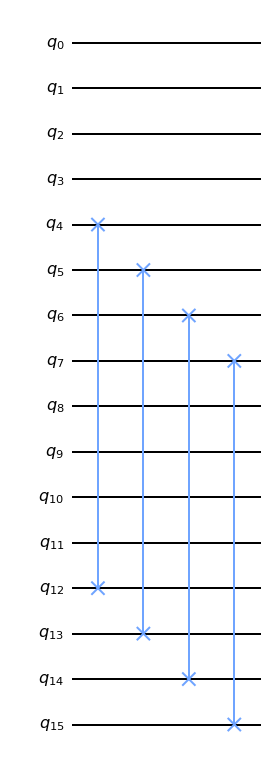

In [47]:
sr = QuantumCircuit(16)
qubits = [
    [4,12],
    [5,13],
    [6,14],
    [7,15],
]

for i in qubits:
    sr.swap(i[0],i[1])

sr.draw('mpl')

In [50]:
sr_gate = sr.to_gate()
sr_gate.name = 'SR'

### Add round key

In [51]:
ark = QuantumCircuit(32)
offset = 16
for i in range(16):
    ark.cnot(i, index + i)
ark_gate = ark.to_gate()
ark_gate.name = 'AK'

### round1 key

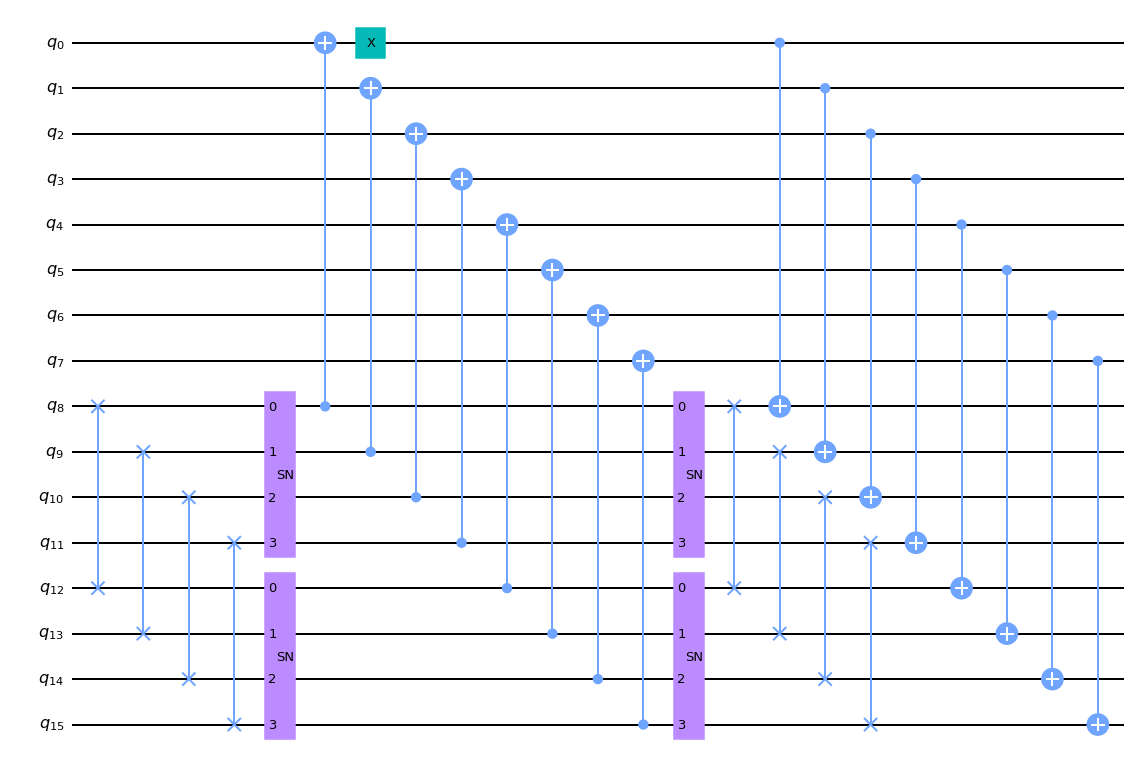

In [70]:
r1k = QuantumCircuit(16)
for i in range(4):
    r1k.swap(8 + i, 12 + i)

r1k.append(sbox_gate, range(8,12))
r1k.append(sbox_gate, range(12,16))

for i in range(8):
    r1k.cnot(8+i, i)

# rcon = 10000000
r1k.x(0)

# Reverse
r1k.append(sbox_gate, range(8,12))
r1k.append(sbox_gate, range(12,16))

for i in range(4):
    r1k.swap(8 + i, 12 + i)

for i in range(8):
    r1k.cnot(i, i+8)


r1k.draw('mpl')

In [71]:
r1k_gate = r1k.to_gate()
r1k_gate.name = 'R1K'

### round2 key

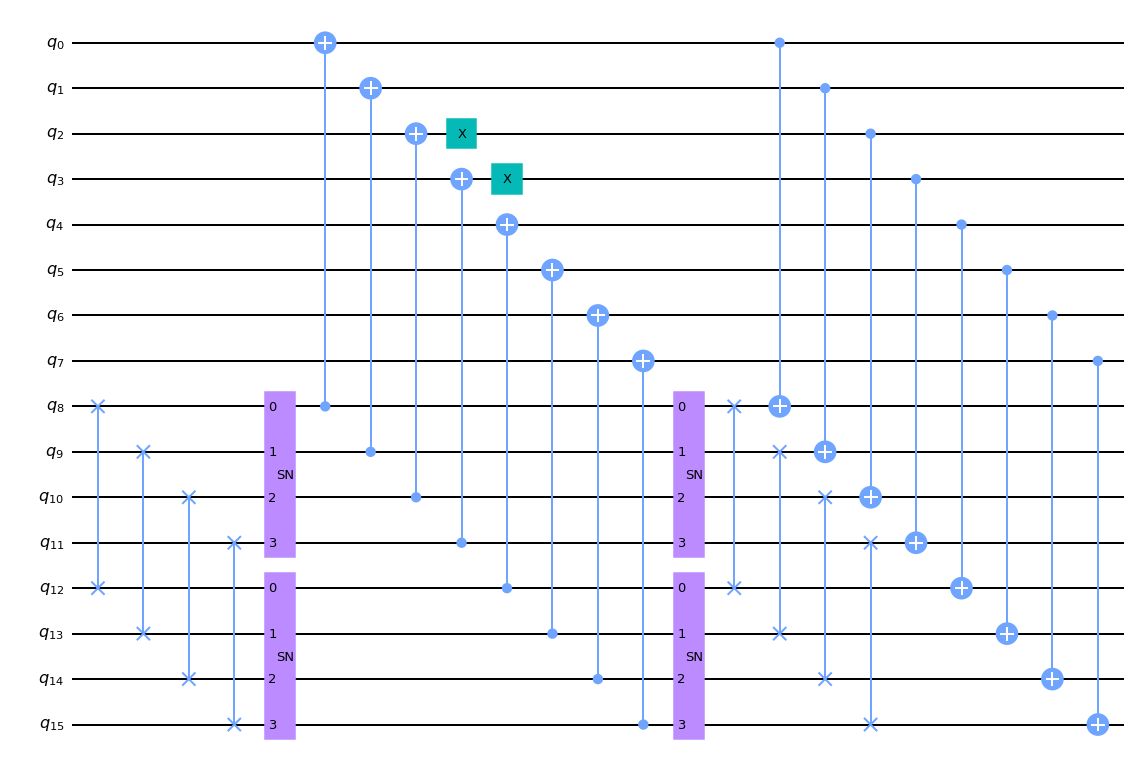

In [75]:
r2k = QuantumCircuit(16)
for i in range(4):
    r2k.swap(8 + i, 12 + i)

r2k.append(sbox_gate, range(8,12))
r2k.append(sbox_gate, range(12,16))

for i in range(8):
    r2k.cnot(8+i, i)

# rcon = 00110000
r2k.x(2)
r2k.x(3)

# Reverse
r2k.append(sbox_gate, range(8,12))
r2k.append(sbox_gate, range(12,16))

for i in range(4):
    r2k.swap(8 + i, 12 + i)

for i in range(8):
    r2k.cnot(i, i+8)


r2k.draw('mpl')

In [76]:
r2k_gate = r2k.to_gate()
r2k_gate.name = 'R2K'

### SAES21

In [52]:
msg = '0110111101101011'
key = '1010011100111011'
#cipher = '0000011100111000'

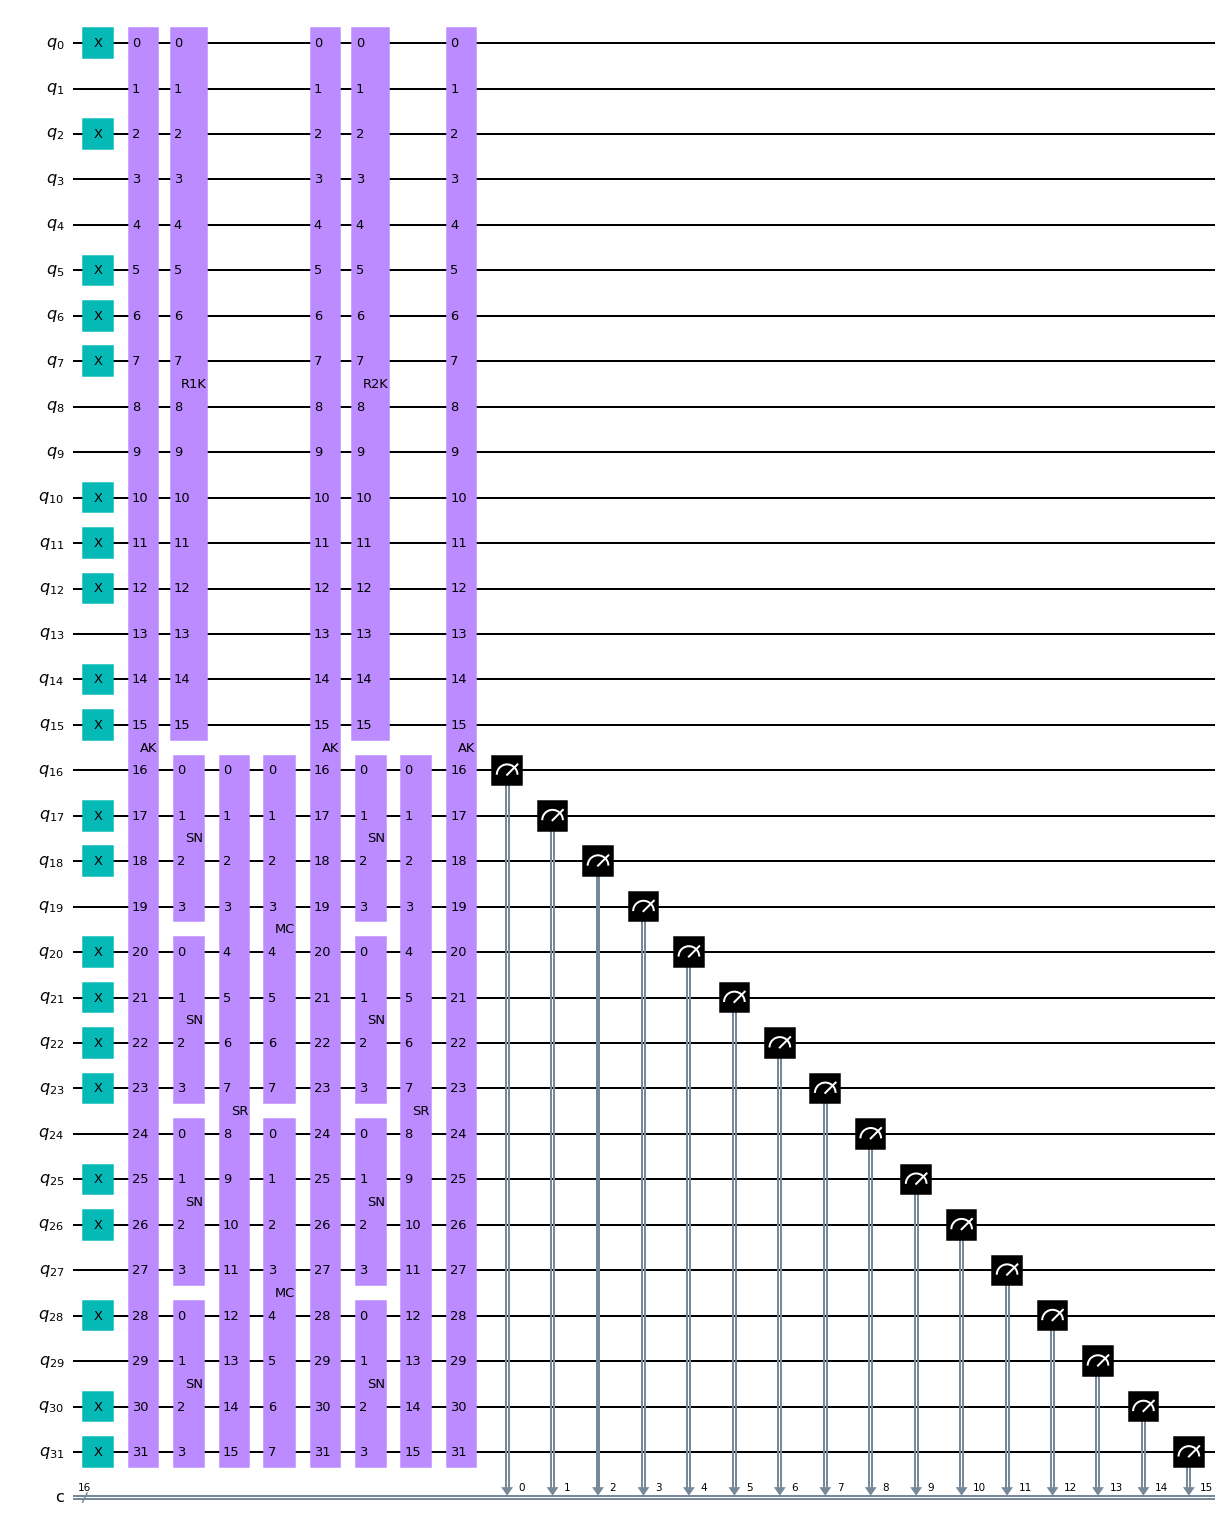

In [80]:
saes = QuantumCircuit(32,16)


# first 16 qubits for key
# later for plaintext

offset = 16
for index, i in enumerate(key):
    if i == '1':
        saes.x(index)
        
for index, i in enumerate(msg):
    if i == '1':
        saes.x(offset + index)

# xor key with plaintext
saes.append(ark_gate, range(32))
saes.append(sbox_gate, range(16,20))
saes.append(sbox_gate, range(20,24))
saes.append(sbox_gate, range(24,28))
saes.append(sbox_gate, range(28,32))
saes.append(sr_gate, range(16,32))
saes.append(mc_gate, range(16,24))
saes.append(mc_gate, range(24,32))
saes.append(r1k_gate,range(16))
saes.append(ark_gate, range(32))
saes.append(sbox_gate, range(16,20))
saes.append(sbox_gate, range(20,24))
saes.append(sbox_gate, range(24,28))
saes.append(sbox_gate, range(28,32))
saes.append(sr_gate, range(16,32))
saes.append(r2k_gate,range(16))
saes.append(ark_gate, range(32))    
saes.measure(np.arange(16,32,1), range(16))
saes.draw('mpl')

In [87]:
shots = 1
simulator = Aer.get_backend('aer_simulator')
res = execute(saes,backend=simulator, shots=shots).result()
res

Simulation failed and returned the following error message:
ERROR:  [Experiment 0] Insufficient memory to run circuit circuit-42805 using the statevector simulator.


Result(backend_name='aer_simulator', backend_version='0.10.3', qobj_id='eb3cf6a8-21ee-47c1-8631-c5a5bb337c3a', job_id='8baf9564-1811-4fa0-bcaf-7e34da1d1e61', success=False, results=[ExperimentResult(shots=0, success=False, meas_level=2, data=ExperimentResultData(), status=ERROR: Insufficient memory to run circuit circuit-42805 using the statevector simulator., seed_simulator=0, metadata={'noise': 'ideal', 'batched_shots_optimization': False, 'measure_sampling': False, 'device': 'CPU', 'num_qubits': 32, 'remapped_qubits': False, 'method': 'statevector', 'active_input_qubits': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31], 'num_clbits': 16, 'input_qubit_map': [[31, 31], [30, 30], [29, 29], [28, 28], [27, 27], [26, 26], [25, 25], [24, 24], [23, 23], [22, 22], [21, 21], [20, 20], [19, 19], [18, 18], [17, 17], [16, 16], [5, 5], [4, 4], [3, 3], [2, 2], [0, 0], [1, 1], [6, 6], [7, 7], [8, 8], [9, 9], [10, 10], [11, 11], 